In [1]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# %load_ext autoreload
# %autoreload 2
# from trader.tradertk import *
# from trader.tradertk_class import *

In [2]:
def get_data(file_name):
    stock_data = pd.read_csv(file_name)
    
    # Sort data by date.
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data = stock_data.sort_values(by='Date')
    stock_data.reset_index(drop=True, inplace=True)
    
    sliced_data = stock_data['Open']

    # Just getting returns.
    returns = [0]
    for i in range(1, len(sliced_data)):
        returns.append(sliced_data[i] - sliced_data[i-1])
    
    plt.plot(sliced_data)
    plt.title(file_name)
    plt.xlabel('time')
    plt.show()
    
    return sliced_data, returns

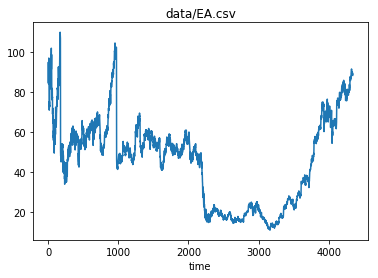

In [3]:
data, returns = get_data('data/EA.csv')

In [106]:
class Trader:
    """
    Trader class.
    Start trading using initial parameters.

    Parameters
    ----------
    just_data : list
        List of prices.
    returns : list
        List of returns.
    M : int
        The number of time series inputs to the trader.
    window_size : int
        Size of historical window.
    n_steps : int
        Number of steps to make predictions.
    start_position : int
        Start-postion time step.
    name : str
        The name of Stocks (the default is '_').
    miu : float, optinonal
        Maximum possible number of shares per trasaction (the default is 1).
    delta : float, optinonal
        The cost for a transaction at period t (the default is 0.0006, which is
        used at stocks in Moscow).
    num_iter_learn : int, optinonal
        (the default is 0.01).
    learning_rate_0 : float, optinonal
        Learning rate (the default is 0.01).
    is_dynam_lr : bool, optional
        Flag to use or not dynamic learning rate (the default is False).
    debug : bool, optional
        Flag to calculate or not numerical grads (the default is False).

    Returns
    -------
    Nothing. It just trades.

    """
    def __init__(self, returns, M, window_size, n_steps, start_position, features_size=0,
                 name='_', miu=1, delta=0.0006, num_iter_learn=100,
                 learning_rate_0=0.01, is_dynam_lr=False, debug=False):

        self.returns = returns
        self.M = M
        self.features_size = features_size
        self.window_size = window_size
        self.n_steps = n_steps
        self.start_position = start_position

        self.name = name
        self.miu = miu
        self.delta = delta
        self.num_iter_learn = num_iter_learn
        self.learning_rate_0 = learning_rate_0
        self.learning_rate = learning_rate_0
        self.is_dynam_lr = is_dynam_lr

        # Weights initialization.
        self.w = np.random.uniform(-0.1, 0.1, self.M + 3)
        self.F_predictions = []  # Agent's actions.

        # They are both needed for training.
        self.F_last_value = 0
        self.F_first_value = 0

        self.dFdW_last_values = np.zeros(self.w.shape)

        # Use `self.t1` as iterator from `start_position`
        # to `start_position` + `n_steps`.
        self.t1 = self.start_position
        self.t_pred = self.t1 + self.window_size

    def one_step(self):
        """
        Make one step. Predict for the next day. The goal is to iterate from start_position to start_position + n_steps.

        """
        self.t_pred = self.t1 + self.window_size

        if self.is_dynam_lr:
            # Dynamic learning rate.
            self.learning_rate = self.learning_rate_0 * (self.n_steps - self.t1) / self.n_steps
        else:
            self.learning_rate = self.learning_rate_0

        # Training on previous history.
        self.train_on_history()

        # Make prediction for time_step t1 + 1.
        self.F_predictions.append(self.predict())

        self.t1 += 1
        
    def predict(self):
        return self.trader_function(self.build_x_vector(self.t_pred, self.M, self.returns, self.F_last_value), self.w)

    def train_on_history(self):
        # Training on previous history.
        for _ in range(self.num_iter_learn):
            X = self.build_x_matrix(self.t1, self.window_size, self.M, self.returns, self.w, self.F_first_value)

            # Just getting last coordinate of vectors from matrix X.
            F = self.get_trader_func(X)

            # Calculate rewards and sharpe.
            Rewards, s_ratio = self.get_rewards(self.t1, self.returns, F, self.miu, self.delta)

            # Calculate gradient dF/dW.
            numeric_dFdW, dFdW = self.get_grad_F_w(X, self.w, self.dFdW_last_values)

            # Calculate gradient dS/dW.
            numeric_grad, grad = self.get_grad_S_w(self.t1, Rewards, self.returns, F, self.miu, self.delta, dFdW, self.w, self.F_first_value)

            # Update weights.
            self.w += self.learning_rate * grad
        # End of the training on history.

        self.F_first_value = F[1]
        self.F_last_value = F[-1]

        self.dFdW_last_values = dFdW[-1]

    def get_rewards_sharpe_money(self):
        # Calculate rewards and sharpe on predicted data.
        rewards_predictions, sharp = self.get_rewards(self.start_position + self.window_size, self.returns,
                                                 np.array(self.F_predictions), self.miu, self.delta)

        # Just calculating the money we've earned [or lost].
        money = [0]
        for i in range(1, len(rewards_predictions)):
            money.append(sum(rewards_predictions[:i]))
            
        return rewards_predictions, sharp, money
        
    def sharp_ratio(self, rewards):
        """
        Calculate sharp_ratio.

        Parameters
        ----------
        rewards : list
            List of rewards till time t.

        Returns
        -------
        float
            Sharpe ratio at time step t.

        """
        EPS = 1e-7

        return np.mean(rewards) / (np.std(rewards) + EPS)


    def get_rewards(self, time_pos, returns, Ft, miu, delta):
        """
        Calculate rewards till time step `time_pos`.

        Parameters
        ----------
        time_pos : int
            Start-postion time step.
        returns : list
            List of returns till time step `time_pos`.
        Ft : list
            Holdings at time steps.
        miu : float
            Maximum possible number of shares per transaction.
        delta : float
            The cost for a transaction at period t.

        Returns
        -------
        ans : list
            List of Rewards till time t.
        s_ratio : float
            Sharp ratio at time step `time_pos`.

        """
        ans = [0]

        tmp = miu * ((Ft[:-1] * returns[1 + time_pos:len(Ft) + time_pos]) -
                     (delta * abs(Ft[1:] - Ft[:-1])))

        ans.extend(tmp)

        s_ratio = self.sharp_ratio(ans)

        return ans, s_ratio


    def build_x_matrix(self, time_pos, window_size, M, returns, w, Ft_prev):
        """
        Build matrix X of windows x_t. Size of every window is (M + 3).

        Parameters
        ----------
        time_pos : int
            Start-postion time step.
        window_size : int
            Size of historical window.
        M : int
            The number of time series inputs to the trader.
        returns : list
            List of returns.
        w : list
            Weights.
        Ft_prev : float

        Returns
        -------
        X : array of lists
            Array of windows x_t.

        """
        X = np.zeros((window_size, M + 3))

        X[0] = np.concatenate(([1], list(reversed(returns[time_pos:1 + time_pos])),
                               np.zeros(M), [Ft_prev]))

        for time_step in range(1, M + 1):
            X[time_step] = np.concatenate(([1], list(reversed(
                               returns[time_pos:time_pos + time_step + 1])),
                               np.zeros(M - time_step),  # Padding with zeros.
                               [self.trader_function(w, X[time_step - 1])]))
        # There is one difference. In the code above zeros are added.
        for time_step in range(M + 1, window_size):
            X[time_step] = np.concatenate(([1], list(reversed(
                               returns[time_pos + time_step - M:
                                       time_pos + time_step + 1])),
                               [self.trader_function(w, X[time_step - 1])]))
        return X


    def build_x_vector(self, time_pos, M, returns, Ft_last):
        """
        Build an array - historical window x_t. Its length is (M + 3).

        Parameters
        ----------
        time_pos : int
            Time step to predict the agent's action in.
        M : int
            The number of time series inputs to the trader.
        returns : list
            List of returns.
        Ft_last : float
            Previois action of agent.

        Returns
        -------
        list
            Historical window x_t.

        """
        return np.concatenate(([1], list(reversed(returns[time_pos - M:time_pos + 1])), [Ft_last]))


    def get_trader_func(self, X):
        """
        Get only last coordinates of vectors in matrix X.

        Parameters
        ----------
        X : list

        Returns
        -------
        list
            Values of trader function - the actions of agent.

        """
        return np.array(X)[:, -1]


    def get_grad_F_w(self, X, w, dFdW_last):
        """
        Calculate gradient dF/dW.

        Parameters
        ----------
        X, w : list
        dFdW_last : list
            Gradient from last epoch.

        Returns
        -------
        dFdW : matrix
            Calculated gradient dF/dW.

        """
        def numeric_grad(x):
            d = 1e-5
            ans = np.zeros(w.shape)

            for i in range(len(w)):
                tmp = np.zeros(w.shape)
                tmp[i] = d
                ans[i] = (self.trader_function(x, w + tmp) -
                          self.trader_function(x, w - tmp)) / (2 * d)
            return ans

        dFdW = np.zeros(X.shape)
        numeric_dFdW = np.zeros(X.shape)
        # Define first dF/dW gradient of output matrix dFdW.
        dFdW[0] = (1 - (self.trader_function(X[0], w) ** 2)) * (X[0] +
                                                           (w[-1] * dFdW_last))
        numeric_dFdW[0] = numeric_grad(X[0])
        for time_step in range(1, len(X)):
            dFdW[time_step] = (1 - (self.trader_function(X[time_step], w) ** 2)) * \
                              (X[time_step] + (w[-1] * dFdW[time_step-1]))
            numeric_dFdW[time_step] = numeric_grad(X[time_step])
        return numeric_dFdW, dFdW


    def get_grad_S_w(self, time_pos, rewards, returns, Ft, miu, delta, dFdW, w,
                     Ft_first):
        """
        Calculate gradient dS/dW.

        Parameters
        ----------
        time_pos : int
        rewards : list
            List of Rewards.
        returns : list
            List of returns.
        Ft : list
            List of values of trader function.
        dFdW : list
            List of gradients dF/dW.
        miu, delta : float
        w : list
        Ft_first : float

        Returns
        -------
        grad : float
            Calculated gradient dS/dW.

        """
        A = sum(rewards) / len(rewards)
        B = sum(np.array(rewards) ** 2) / len(rewards)

        dSdA = (1 / np.sqrt(B - (A ** 2))) + ((A ** 2) / ((B - (A ** 2)) ** (3/2)))
        dSdB = -1 * (A / (2 * (((B - (A ** 2))) ** (3/2))))

        grad = 0.0

        # There are many points of code optimization and improvement.
        for t in range(1, len(rewards)):
            dAdR = 1 / len(rewards)
            dBdR = 2 * rewards[t] / len(rewards)

            dRdFt = -1 * miu * delta * np.sign(Ft[t] - Ft[t-1])
            dRdFtt = (miu * returns[time_pos+t]) - dRdFt

            dFtdw = dFdW[t]
            dFttdw = dFdW[t-1]

            grad += (dSdA*dAdR + dSdB*dBdR) * (dRdFt*dFtdw + dRdFtt*dFttdw)

        def numeric_grad():

            def help_func(w_tmp):
                X = self.build_x_matrix(time_pos, len(rewards), len(dFdW[0]) - 3, returns, w_tmp, Ft_first)
                F = self.get_trader_func(X)
                _, s_ratio = self.get_rewards(time_pos, returns, F, miu, delta)
                return s_ratio

            d = 1e-6
            ans = np.zeros(w.shape)
            for i in range(len(w)):
                tmp = np.zeros(w.shape)
                tmp[i] = d
                ans[i] = (help_func(w + tmp) - help_func(w - tmp)) / (2 * d)
            return ans

        return numeric_grad(), grad


    def trader_function(self, X, w):
        """
        Represents the trading position at time t. Holdings at period t.
        Three types of positions that can be held: `long` (> 0),
        `short` (< 0), `neutral` (= 0).

        Parameters
        ----------
        X, w : list

        Returns
        -------
        float
            Value of trader_function.

        """
        return np.tanh(np.dot(X, w))


In [108]:
# agent_run(returns, name='EA', M=2, window_size=3, n_steps=1000, start_position=0, num_iter_learn=10)

In [110]:
tt = Trader(returns, M=3, window_size=4, n_steps=1000, start_position=0, num_iter_learn=10, name='EA')

for i in tqdm.tqdm(range(1000)):
    tt.one_step()

100%|██████████| 1000/1000 [00:36<00:00, 27.27it/s]


In [100]:
rewards, sharp, money = tt.get_rewards_sharpe_money()

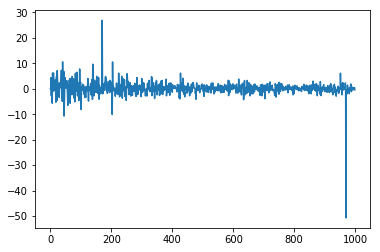

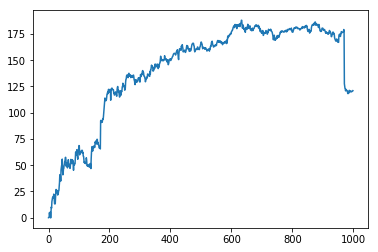

In [101]:
plt.plot(rewards)
plt.show()
plt.plot(money)
plt.show()